# Naïve Bayes Text Classification

__Team Members:__ Surya Suresh Sriraman, Nivetha Sivakumar, Aravind Raju

# Introduction

## Sentiment Analysis of Movie Reviews using Naive Bayes

__Problem:__ We want to understand the sentiment (positive or negative) expressed in movie reviews. This can be valuable for various applications, such as:

- Helping movie studios gauge audience reception.
- Recommending movies to users based on their preferences.
- Identifying trends in public opinion about movies.

This work will explore a dataset comprised of 1000 positive and 1000 negative movie reviews sourced from this site: http://www.cs.cornell.edu/people/pabo/movie-review-data/ .We will build a Naive Bayes classification model to analyze movie reviews and categorize them as positive or negative.  Here's how we'll approach the problem:

__Approach:__

- __Data Acquisition:__ Utilize Python and the Pandas library to load the data into a suitable DataFrame.
- __Data Preprocessing:__ Clean the review text by removing punctuation, stop words, and converting all words to lowercase.
- __Frequency Distribution Plots:__ Explore and analyze the dataset to identify modet frequent words.
- __Naïve Bayes Model Training:__ Train a Naive Bayes classifier using the preprocessed reviews and their corresponding sentiment labels (positive or negative).
- __Model Evaluation:__ Test the trained model on unseen reviews to assess its accuracy in predicting sentiment.

# Data Preparation

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from IPython.display import clear_output

def clrscr():
    clear_output(wait=True)

## Data Loading and Processing

In [3]:
# GitHub repository URL
positive_reviews_directory = r'https://github.com/s-surya-s/DAV-6150/tree/main/M10_data/pos'
negative_reviews_directory = r'https://github.com/s-surya-s/DAV-6150/tree/main/M10_data/neg'

In [4]:
# Define stopwords and initialize the stemmer
stop_words = set(stopwords.words('english'))
porter = nltk.PorterStemmer()

In [5]:
def preprocess_text(text):    
    """
    Preprocesses the input text by converting it to lowercase, 
    removing punctuation, tokenizing it, removing stopwords, 
    and performing stemming.
    
    Args:
    text (str): The input text to be preprocessed.
    
    Returns:
    list: A list of preprocessed tokens.
    """
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text
    tokens = word_tokenize(text)
    
    # Remove stopwords and perform stemming
    filtered_tokens = [porter.stem(token) for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    return lemmatized_tokens

In [6]:
def extract_reviews(url):
    """
    Extracts reviews from a given URL.
    
    Args:
    url (str): The URL of the directory containing review files.
    
    Returns:
    list: A list of preprocessed reviews.
    """
    reviews = []  # List to store extracted reviews
    
    try:
        # Send a GET request to the provided URL
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors
        
        # Parse the HTML content of the response using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Define a regular expression pattern to extract file names
        pattern = r'{"name":"([^"]+.txt)"'
        
        # Find all matches of the pattern in the HTML content
        file_names = re.findall(pattern, str(soup))
        
        log = 0  # Variable to track progress
        total = len(file_names)  # Total number of files
        
        # Iterate over each file name found
        for file_name in file_names:
            # Construct the URL for the file
            file_url = f'{url}/{file_name}'
            # Modify the file URL to point to the raw file on GitHub
            file_url = file_url.replace("github.com", "raw.githubusercontent.com").replace("/tree/", "/")
            
            log += 1  # Increment progress counter
            progress = int(100 * log/total)  # Calculate progress percentage
            
            # Print progress information
            print(f'{progress}%')
            print(f'{log}/{total} : Loading data from {file_url}')
            clrscr()
            
            try:
                # Send a GET request to the file URL
                file_response = requests.get(file_url)
                file_response.raise_for_status()  # Raise an exception for HTTP errors
                
                # Get the content of the file
                file_content = file_response.text
                # Preprocess the content to extract reviews
                processed_review = preprocess_text(file_content)
                # Append the processed review to the list of reviews
                reviews.append(processed_review) 
            except requests.HTTPError as e:
                print(f"Failed to fetch data from file '{file_url}': {e}")
    except requests.HTTPError as e:
        print(f"Failed to access directory at '{url}': {e}")
    
    print('Load Successful')
    
    return reviews

In [7]:
positive_reviews = extract_reviews(positive_reviews_directory)

Load Successful


In [8]:
negative_reviews = extract_reviews(negative_reviews_directory)

Load Successful


In [9]:
# Create vocabulary
vocabulary = set()
for review in positive_reviews + negative_reviews:
    vocabulary.update(review)

In [10]:
# Initialize an empty DataFrame for the term-document matrix
term_document_matrix = pd.DataFrame(0,
                                    index=range(len(positive_reviews) + len(negative_reviews)),
                                    columns=['Sentiment']+list(vocabulary))

# Populate term-document matrix with word frequencies
for idx, review in enumerate(positive_reviews):
    for word in review:
        term_document_matrix.loc[idx, word] += 1
    term_document_matrix.loc[idx, 'Sentiment'] = 'POS'

for idx, review in enumerate(negative_reviews, start=len(positive_reviews)):
    for word in review:
        term_document_matrix.loc[idx, word] += 1
    term_document_matrix.loc[idx, 'Sentiment'] = 'NEG'

term_document_matrix.head()

,Sentiment,cowmoo,debt,mysterygirlwhosnorealmysteri,00,homoerotic,shield,talk,instantgratif,wars_,...,kristi,cultfavorit,overthrow,diplomat,leviathan,storytel,mastrantonio,tougher,wroth,percept
0,POS,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,POS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,POS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,POS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,POS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Frequency Distribution Plots

In [11]:
def plot_frequency_distribution(term_document_matrix, sentiment):
    # Filter term-document matrix by sentiment
    filtered_matrix = term_document_matrix[term_document_matrix['Sentiment'] == sentiment]
    
    # Get frequency counts for all words
    word_counts = filtered_matrix.drop(columns=['Sentiment']).sum(axis=0)
    
    # Get top 30 most frequent words
    top_30_words = word_counts.sort_values(ascending=False).head(30)
    
    # Plot frequency distribution
    plt.figure(figsize=(12, 6))
    top_30_words.plot(kind='bar')
    plt.title(f'Frequency Distribution of Top 30 Words in {sentiment} Reviews')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Top frequent words in the positive reviews

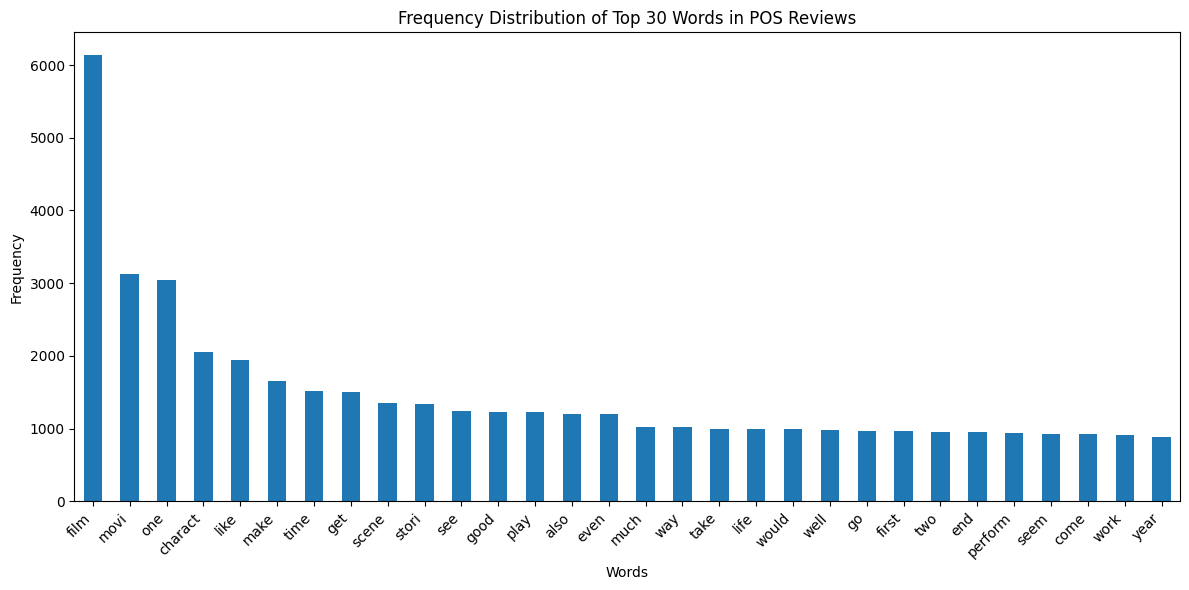

In [12]:
plot_frequency_distribution(term_document_matrix, 'POS')

__Insights:__

### Top frequent words in the positive reviews

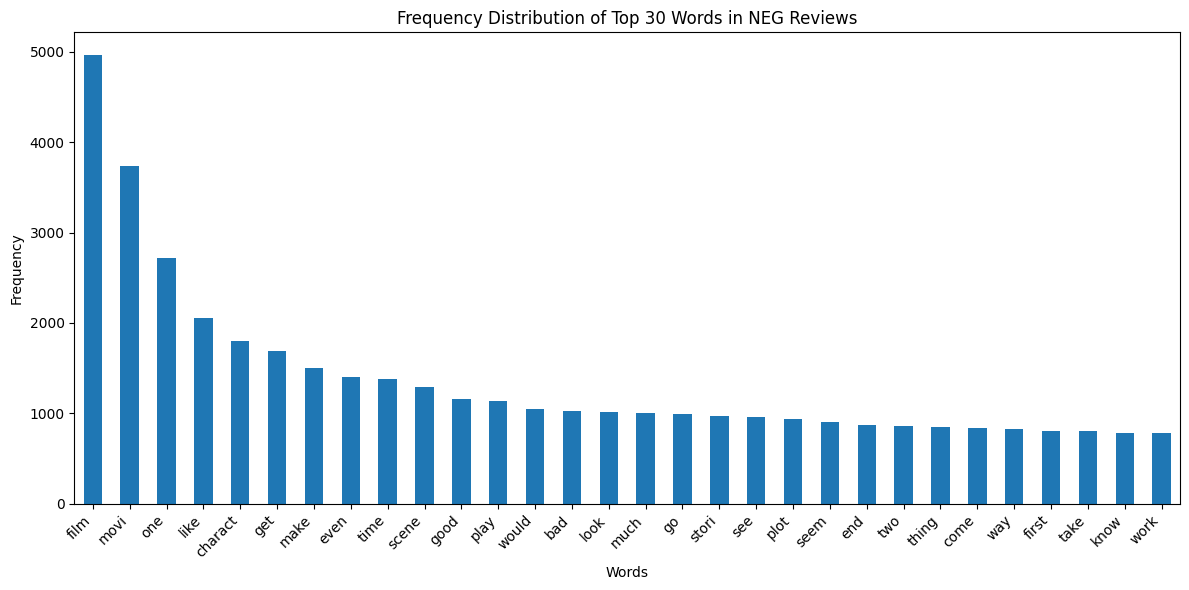

In [13]:
plot_frequency_distribution(term_document_matrix, 'NEG')

__Insights:__

# Naïve Bayes Model Training

## Split the data

In [14]:
# Separate features (X) and target variable (y)
X = term_document_matrix.drop(columns=['Sentiment'])
y = np.where(term_document_matrix['Sentiment'] == 'POS', 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Display the shape of training and testing data
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1500, 32045)
Testing data shape: (500, 32045)


In [15]:
# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier using the training data
nb_classifier.fit(X_train, y_train)

MultinomialNB()

# Model Testing

Evaluation on Test Set:


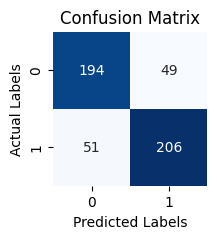


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       243
           1       0.81      0.80      0.80       257

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500



{'Accuracy': 0.8, 'Precision': 0.81, 'Recall': 0.8, 'F1-Score': 0.8}

In [16]:
# Predict the sentiment for the testing data
y_pred = nb_classifier.predict(X_test)

print("Evaluation on Test Set:")
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True, cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

{
    'Accuracy': round(accuracy_score(y_test, y_pred), 2),
    'Precision': round(precision_score(y_test, y_pred), 2),
    'Recall': round(recall_score(y_test, y_pred), 2),
    'F1-Score': round(f1_score(y_test, y_pred), 2)
}

# Top Informative Features

In [17]:
# Get the feature log probabilities for each class
feature_log_probs = nb_classifier.feature_log_prob_

# Get the feature names (words)
feature_names = X.columns

# Create a DataFrame to store feature names and log probabilities
feature_log_probs_df = pd.DataFrame(feature_log_probs, columns=feature_names)

# Transpose the DataFrame to have features as rows and classes as columns
feature_log_probs_df = feature_log_probs_df.T

# Rename the columns to indicate the classes
feature_log_probs_df.columns = ['Negative', 'Positive']

# Sort the DataFrame by the absolute difference between log probabilities
feature_log_probs_df['Difference'] = abs(feature_log_probs_df['Negative'] - feature_log_probs_df['Positive'])
top_informative_features = feature_log_probs_df.sort_values(by='Difference', ascending=False)

# Display the top 30 informative features
print("Top 30 Informative Features:")
print(top_informative_features.head(30))

Top 30 Informative Features:
              Negative   Positive  Difference
nbsp         -8.471117 -12.633410    4.162293
gattaca     -12.548655  -8.919838    3.628817
shrek       -12.548655  -8.995824    3.552831
brenner      -9.082919 -12.633410    3.550491
sphere       -9.181359 -12.633410    3.452051
werewolf     -9.216450 -12.633410    3.416960
leila       -12.548655  -9.167674    3.380981
mulan       -11.855508  -8.490275    3.365232
mallori     -12.548655  -9.266114    3.282540
seagal       -8.698507 -11.940263    3.241756
krippendorf  -9.413161 -12.633410    3.220250
lambeau     -12.548655  -9.337573    3.211081
sweetback   -12.548655  -9.375314    3.173341
guido       -12.548655  -9.375314    3.173341
nello       -12.548655  -9.414534    3.134120
babysitt     -9.504132 -12.633410    3.129278
psychlo      -9.504132 -12.633410    3.129278
pokemon      -9.504132 -12.633410    3.129278
bye          -9.504132 -12.633410    3.129278
feihong     -12.548655  -9.455356    3.093298
lama 

## Unseen Data

In [18]:
new_review = '''There were some things I didn't like about this film. Here's what I remember most strongly: a man in an ingeniously fake-looking polar bear costume (funnier than the "bear" from Hercules in New York); an extra with a less than believable laugh; an ex-drug addict martian with tics; child actors who recite their lines very slowly and carefully; a newspaper headline declaring that Santa has been "kidnapped", and a giant robot. The least appealing acting job in the film must be when Mother Claus and her elves have been "frozen" by the "Martians'" weapons. They seemed to display an exaggerated amount of fear. Perhaps this was the preferred acting style in the 1960's??'''

In [19]:
processed_new_review = preprocess_text(new_review)

# Create a DataFrame with word frequencies for the review
review_tdm= pd.DataFrame(0, index=[0], columns=X.columns)
for word in processed_new_review:
    if word in review_tdm.columns:
        review_tdm.loc[0, word] += 1

# Predict the sentiment using the trained classifier
predicted_sentiment = nb_classifier.predict(review_tdm)

# Print the predicted sentiment
print("Predicted Sentiment:", 'Positive' if predicted_sentiment[0]==1 else 'Negative')

Predicted Sentiment: Positive


## Investigate

### Check if new review had words which was not present in the training data

In [20]:
new_review_words = set(processed_new_review)
train_data_words = set(X.columns)

# Find non-common words
non_common = new_review_words.difference(train_data_words)

len(non_common)

0

All the words are present in the training data, so this cant be the reason

### Check feature importance

In [21]:
new_review_words = list(review_tdm.columns[review_tdm.iloc[0] > 0])

new_review_feature_log = feature_log_probs_df.loc[feature_log_probs_df.index.isin(new_review_words)].sort_values(by='Difference', ascending=False)

new_review_feature_log['Sentiment'] = new_review_feature_log.apply(lambda X : 'Positive' if X['Positive'] > X['Negative'] else 'Negative', axis = 1)

new_review_feature_log.head(10)

,Negative,Positive,Difference,Sentiment
here,-8.720013,-10.235515,1.515502,Negative
elv,-11.450042,-12.633410,1.183368,Negative
slowli,-9.370601,-8.428718,0.941883,Positive
1960,-10.351430,-9.414534,0.936896,Positive
hercul,-11.162360,-10.235515,0.926846,Positive
strongli,-10.469213,-9.542368,0.926846,Positive
declar,-10.246070,-9.414534,0.831535,Positive
tic,-11.855508,-11.023972,0.831535,Positive
ingeni,-10.756895,-9.994353,0.762542,Positive
martian,-9.413161,-10.148503,0.735343,Negative


Based on out trainig dataset, top Informative features based on the new review are demonstrating Positive sentiment. Hence, the review is predicted as Positive.

# Conclusions

This project demonstrated the application of Naive Bayes for sentiment analysis of movie reviews. We constructed a term-document matrix, explored word frequencies, and trained a model to classify reviews as positive or negative. The model achieved an accuracy of 80% on the testing data. Analyzing informative features revealed words that were most influential in sentiment classification. 

However, the model's prediction for the unseen review was incorrect. This highlights the limitations of sentiment analysis models, particularly in capturing nuances like sarcasm or complex language. Further exploration could involve Training on a more extensive dataset.

Despite the misclassification of the unseen review, this project provided valuable insights into sentiment analysis using Naive Bayes. By addressing the model's limitations, we can enhance its accuracy and real-world applicability.